In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import os

## Data read

In [2]:
DATA_PATH = "./data/used_cars.csv"

In [3]:
data = pd.read_csv(DATA_PATH)

## Quick overview

In [4]:
data.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


In [5]:
data.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [8]:
print("Clean title unique: ", data.clean_title.unique())
print("Accident unique: ", data.accident.unique())
print("transmission unique: ", data.transmission.unique())
print("fuel_type unique: ", data.fuel_type.unique())

Clean title unique:  ['Yes' nan]
Accident unique:  ['At least 1 accident or damage reported' 'None reported' nan]
transmission unique:  ['6-Speed A/T' '8-Speed Automatic' 'Automatic' '7-Speed A/T' 'F' 'A/T'
 '8-Speed A/T' 'Transmission w/Dual Shift Mode' '9-Speed Automatic'
 '6-Speed M/T' '10-Speed A/T' '9-Speed A/T' '5-Speed A/T' '1-Speed A/T'
 'Automatic CVT' '7-Speed Automatic with Auto-Shift' 'CVT-F' 'M/T'
 '6-Speed Automatic with Auto-Shift' '10-Speed Automatic'
 'CVT Transmission' '4-Speed A/T' '6-Speed Automatic' '4-Speed Automatic'
 '7-Speed M/T' '8-Speed Automatic with Auto-Shift' '5-Speed Automatic'
 '8-SPEED AT' '1-Speed Automatic' '5-Speed M/T' 'Manual' '6-Speed Manual'
 'Variable' '2' '7-Speed Manual' 'Automatic, 9-Spd 9G-Tronic'
 'Automatic, 8-Spd' 'Automatic, 8-Spd Sport w/Sport & Manual Modes' '–'
 'Auto, 6-Spd w/CmdShft' 'Transmission Overdrive Switch'
 '7-Speed Automatic' 'Automatic, 8-Spd PDK Dual-Clutch'
 'Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual M

## Initial cleaning 

### String cleaning

In [9]:
data.brand = data.brand.str.lower()
data.model = data.model.str.lower()
data.fuel_type = data.fuel_type.str.lower()
data.engine = data.engine.str.lower()
data.transmission = data.transmission.str.lower()
data.ext_col = data.ext_col.str.lower()
data.int_col = data.int_col.str.lower()
data.accident = data.accident.str.lower()
data.clean_title = data.clean_title.str.lower()

In [10]:
data.milage = data.milage.str.replace(',', '').str.extract('(\d+)').astype(float)
data.price = data.price.str.replace(',', '').str.extract('(\d+)').astype(float)

### Extracting features

In [11]:
def categorize_transmission(x):
    x = x.lower()
    if 'manual' in x or 'm/t' in x or '6 speed mt' in x or 'manual, 6-spd' in x:
        return 'manual'
    elif 'automatic' in x or 'a/t' in x or 'cvt' in x or 'auto' in x:
        return 'automatic'
    elif 'dual-clutch' in x or 'dct' in x:
        return 'dual_clutch'
    else:
        return 'automatic' 

In [12]:
data["transmission_category"] = data['transmission'].apply(categorize_transmission)

In [13]:
def enhance_dataframe_with_engine_info(df):
    hp_pattern = re.compile(r'(\d+\.?\d*)\s*hp', re.IGNORECASE)
    volume_pattern = re.compile(r'(\d+\.?\d*)\s*l', re.IGNORECASE)
    cylinder_pattern = re.compile(r'(\d+)\s*cylinder', re.IGNORECASE)
    v_cylinder_pattern = re.compile(r'V(\d+)', re.IGNORECASE)
    
    horsepower = []
    engine_volume_l = []
    cylinders = []
    
    for engine_str in df['engine']:
        hp_match = hp_pattern.search(engine_str)
        volume_match = volume_pattern.search(engine_str)
        cylinder_match = cylinder_pattern.search(engine_str)
        v_cylinder_match = v_cylinder_pattern.search(engine_str)
        
        if hp_match:
            horsepower.append(float(hp_match.group(1)))
        else:
            horsepower.append(None)
        
        if volume_match:
            engine_volume_l.append(float(volume_match.group(1)))
        else:
            engine_volume_l.append(None)
        
        if cylinder_match:
            cylinders.append(int(cylinder_match.group(1)))
        elif v_cylinder_match:
            cylinders.append(int(v_cylinder_match.group(1)))
        else:
            cylinders.append(None)

    df['horsepower'] = horsepower
    df['engine_volume_l'] = engine_volume_l
    df['cylinders'] = cylinders
    
    return df

In [14]:
data = enhance_dataframe_with_engine_info(data)

In [15]:
data.accident = data.accident.map({"at least 1 accident or damage reported" : 1, "none reported": 0})

### Cleaning features 

In [16]:
data.isnull().sum()

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type                170
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                 113
clean_title              596
price                      0
transmission_category      0
horsepower               808
engine_volume_l          217
cylinders                622
dtype: int64

In [17]:
def fill_missing_horsepower(df):

    median_hp = df['horsepower'].median()
    median_volume = df['engine_volume_l'].median()
    hp_per_liter = median_hp / median_volume if median_volume else 0
    
    for index, row in df.iterrows():
        if pd.isna(row['horsepower']):
            if not pd.isna(row['engine_volume_l']):
                df.at[index, 'horsepower'] = row['engine_volume_l'] * hp_per_liter
            else:
                brand_median = df[df['brand'] == row['brand']]['horsepower'].median()
                if pd.notna(brand_median):
                    df.at[index, 'horsepower'] = brand_median
                else:
                    df.at[index, 'horsepower'] = median_hp
        

    return df

def fill_missing_fuel_types(df):
    most_common_fuel_by_brand = df.groupby('brand')['fuel_type'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    def fill_fuel_type(row):
        if pd.isnull(row['fuel_type']) or row['fuel_type'] == '–' :
            return most_common_fuel_by_brand[row['brand']]
        else:
            return row['fuel_type']
            
    df.fuel_type = df.apply(fill_fuel_type, axis=1)
    df.fuel_type = df.fuel_type.replace("not supported", "hydrogen")
    df.fuel_type = df.fuel_type.fillna("electric")
    return df


In [18]:
data = fill_missing_horsepower(data)
data = fill_missing_fuel_types(data)

/home/mkapala/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [19]:
data.accident = data.accident.fillna(data.accident.mode()[0])

In [20]:
# data = data.drop(['model','clean_title', "transmission", "engine","engine_volume_l", "ext_col", "int_col" , "cylinders"],axis=1,errors='ignore')

In [21]:
data.isnull().sum()

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type                  0
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                   0
clean_title              596
price                      0
transmission_category      0
horsepower                 0
engine_volume_l          217
cylinders                622
dtype: int64

## Data analysis

In [22]:
data.sample(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,transmission_category,horsepower,engine_volume_l,cylinders
380,toyota,tundra hybrid trd pro,2022,19000.0,hybrid,437.0hp 3.4l v6 cylinder engine gas/electric h...,10-speed a/t,orange,black,0.0,yes,71000.0,automatic,437.000000,3.4,6.0
3427,tesla,model s 100d,2018,83424.0,electric,518.0hp electric motor electric fuel system,1-speed a/t,gray,beige,0.0,yes,45000.0,automatic,518.000000,NaN,NaN
1699,mercedes-benz,amg gt 53 base,2019,35000.0,hybrid,429.0hp 3.0l straight 6 cylinder engine gasoli...,transmission w/dual shift mode,black,black,0.0,yes,83000.0,automatic,429.000000,3.0,6.0
650,lexus,ct 200h premium,2015,101000.0,hybrid,134.0hp 1.8l 4 cylinder engine gas/electric hy...,a/t,black,black,1.0,yes,16500.0,automatic,134.000000,1.8,4.0
2605,mclaren,570s spider,2018,8984.0,gasoline,3.8l v8 32v mpfi dohc twin turbo,7-speed automatic with auto-shift,vega blue,black,0.0,NaN,171900.0,automatic,336.571429,3.8,8.0
3192,lincoln,continental reserve,2017,56846.0,gasoline,335.0hp 2.7l v6 cylinder engine gasoline fuel,transmission w/dual shift mode,white,beige,0.0,yes,29000.0,automatic,335.000000,2.7,6.0
1720,bmw,x6 xdrive35i,2018,27214.0,gasoline,300.0hp 3.0l straight 6 cylinder engine gasoli...,transmission w/dual shift mode,black,black,1.0,yes,40950.0,automatic,300.000000,3.0,6.0
445,audi,q7 3.0t premium,2017,108000.0,gasoline,333.0hp 3.0l v6 cylinder engine gasoline fuel,8-speed a/t,gray,brown,0.0,yes,25999.0,automatic,333.000000,3.0,6.0
3359,chevrolet,express 2500 work van,2017,56000.0,gasoline,285.0hp 4.8l 8 cylinder engine gasoline fuel,a/t,blue,–,0.0,yes,44600.0,automatic,285.000000,4.8,8.0
735,bmw,x7 xdrive50i,2019,31157.0,gasoline,4.4 liter gdi dohc twin turbo,automatic,black,blk,0.0,NaN,65998.0,automatic,389.714286,4.4,NaN


In [23]:
data.describe()

,model_year,milage,accident,price,horsepower,engine_volume_l,cylinders
count,4009.000000,4009.000000,4009.000000,4.009000e+03,4009.000000,3792.000000,3387.000000
mean,2015.515590,64717.551010,0.245947,4.455319e+04,328.470887,3.684454,6.337467
std,6.104816,52296.599459,0.430701,7.871064e+04,122.138198,1.417481,1.666465
min,1974.000000,100.000000,0.000000,2.000000e+03,70.000000,0.650000,3.000000
25%,2012.000000,23044.000000,0.000000,1.720000e+04,240.000000,2.500000,6.000000
50%,2017.000000,52775.000000,0.000000,3.100000e+04,310.000000,3.500000,6.000000
75%,2020.000000,94100.000000,0.000000,4.999000e+04,400.000000,4.700000,8.000000
max,2024.000000,405000.000000,1.000000,2.954083e+06,1020.000000,8.400000,12.000000


array([[<AxesSubplot: title={'center': 'model_year'}>,
        <AxesSubplot: title={'center': 'milage'}>,
        <AxesSubplot: title={'center': 'accident'}>],
       [<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'horsepower'}>,
        <AxesSubplot: title={'center': 'engine_volume_l'}>],
       [<AxesSubplot: title={'center': 'cylinders'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

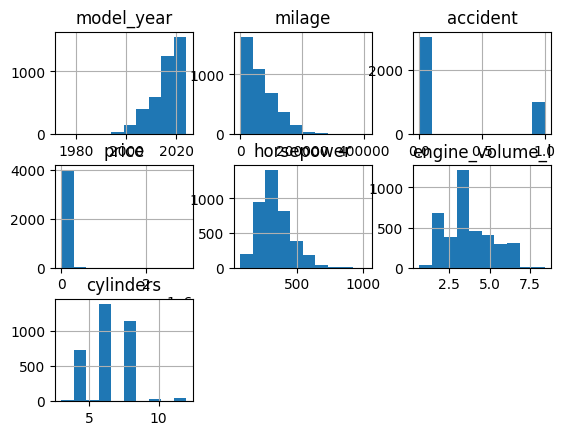

In [24]:
data.hist()

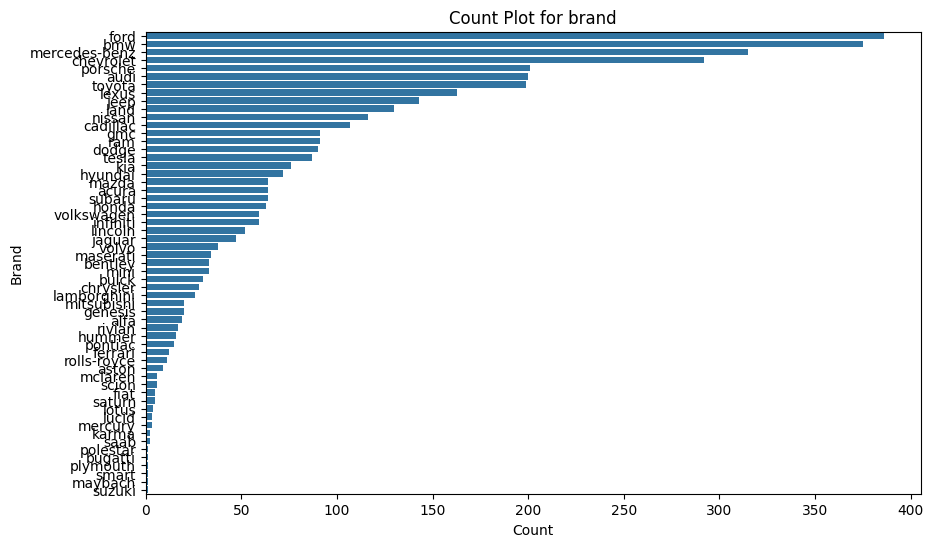

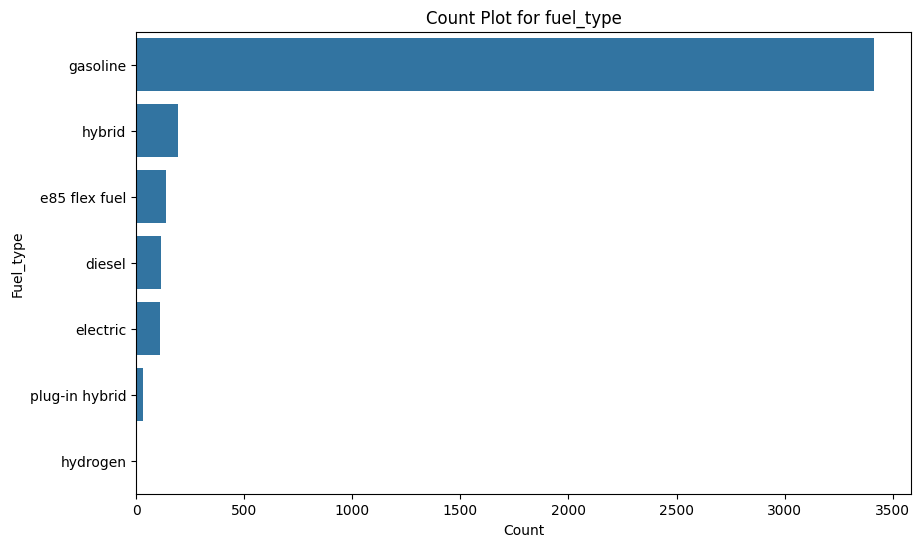

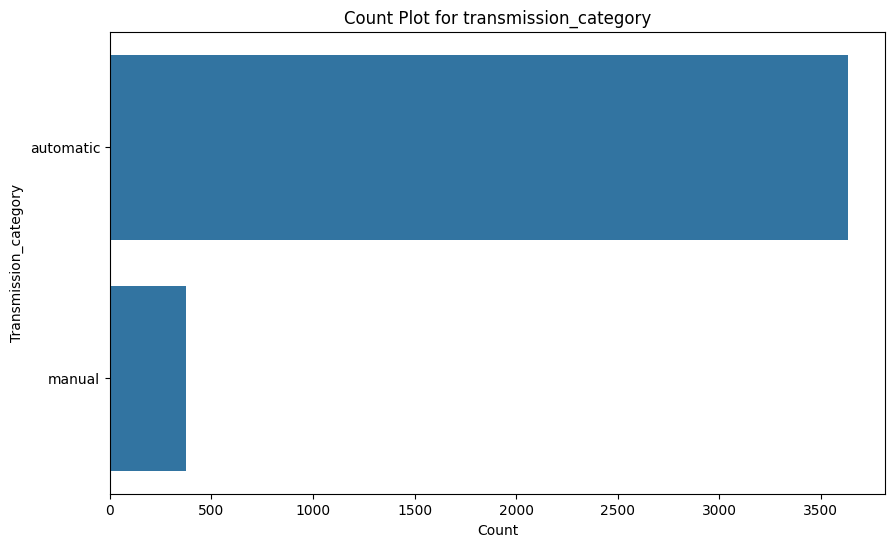

In [25]:
categorical_columns = ['brand', 'fuel_type', 'transmission_category']

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=data, order = data[column].value_counts().index)
    plt.title(f'Count Plot for {column}')
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())
    plt.show()

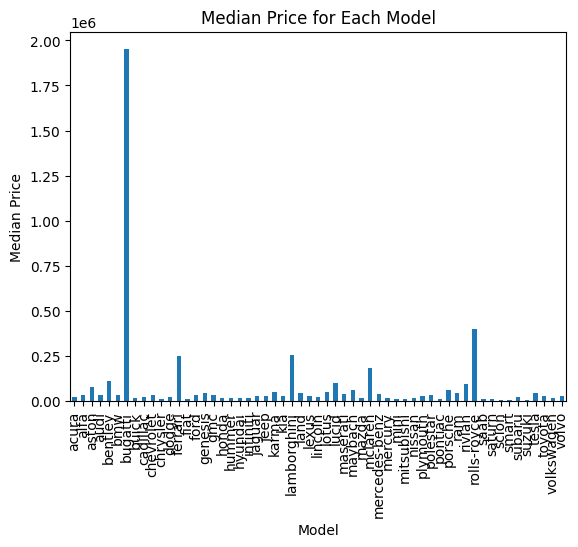

In [26]:
median_prices = data.groupby('brand')['price'].median()

median_prices.plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Median Price')
plt.title('Median Price for Each Model')
plt.show()

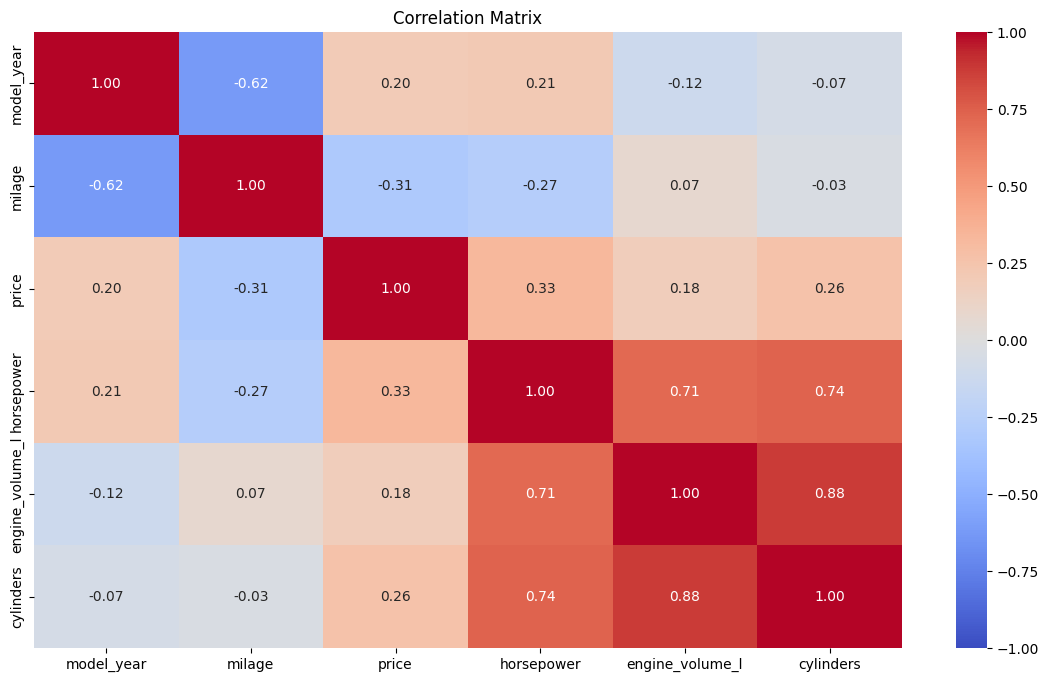

In [27]:
numerical_features = ["model_year", "milage", "price", "horsepower", "engine_volume_l", "cylinders"]
correlation_matrix = data[numerical_features].corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## clean outliers

In [28]:
data = data.drop(data[data['brand'] == 'bugatti'].index)

## Feature selection

In [29]:
X = data[numerical_features].drop(columns=["price"])
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

feature_importance_df.head(20)

,Feature,Importance
1,milage,0.382957
0,model_year,0.228152
2,horsepower,0.182640
4,cylinders,0.108300
3,engine_volume_l,0.097952


In [30]:
data.sample(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,transmission_category,horsepower,engine_volume_l,cylinders
2653,land,rover range rover hse swb,2020,57785.0,hybrid,395.0hp 3.0l straight 6 cylinder engine gasoli...,a/t,black,black,0.0,yes,63995.0,automatic,395.0,3.0,6.0
3513,toyota,highlander hybrid limited platinum,2019,46000.0,hybrid,306.0hp 3.5l v6 cylinder engine gas/electric h...,cvt transmission,silver,black,0.0,yes,40000.0,automatic,306.0,3.5,6.0


In [31]:
data = data.drop(["model", "model_year", "engine", "transmission", "ext_col", "int_col", "clean_title", "engine_volume_l", "cylinders"], axis=1)

## Data standarization

In [32]:
scaler_standard = StandardScaler()
data[["milage", "horsepower"]] = scaler_standard.fit_transform(data[["milage", "horsepower"]])

## Data encoding 

In [33]:
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [34]:
data.sample(10)

,milage,accident,price,horsepower,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,brand_buick,...,brand_toyota,brand_volkswagen,brand_volvo,fuel_type_e85 flex fuel,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_hydrogen,fuel_type_plug-in hybrid,transmission_category_manual
3973,0.978034,0.0,9500.0,-0.371964,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2655,2.192986,1.0,15000.0,-0.101451,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
951,0.674487,1.0,8500.0,-1.437621,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2677,-1.227615,0.0,92500.0,4.152979,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3762,0.177245,0.0,25500.0,-1.183502,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2917,0.119871,1.0,17500.0,-0.953976,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
832,1.620393,1.0,12240.0,0.177259,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1409,-0.155945,0.0,20900.0,-0.986766,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1358,-0.243498,0.0,50000.0,0.177259,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3357,-1.134708,0.0,89900.0,1.324890,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [35]:
data.to_csv("./data/cleaned_car_data.csv")

In [40]:
features = data.drop(["price"], axis=1)
target = data["price"]